In [2]:
!pip install -q keras-tqdm

import math
import os
import pickle
import random
import sys
import time
from contextlib import suppress
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

with suppress(ImportError):
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if os.path.exists('/content/drive/My Drive/SEM/CSC 522 - Automated Learning and Data Analysis/ALDA Project'):
  __BASE_PATH = '/content/drive/My Drive/SEM/CSC 522 - Automated Learning and Data Analysis/ALDA Project'
elif os.path.exists('/content/drive/My Drive/ALDA Project'):
  __BASE_PATH = '/content/drive/My Drive/ALDA Project'
elif '_dh' in globals() and _dh[0]:
  __BASE_PATH = _dh[0]
else:
  __BASE_PATH = os.path.realpath(os.path.basename(sys.argv[0]))

TRAIN_FILE = os.path.join(__BASE_PATH, 'train.csv')
TEST_FILE = os.path.join(__BASE_PATH, 'test.csv')
PREDS_FILE = os.path.join(__BASE_PATH, 'neural_preds.csv')
MODEL_FILE = os.path.join(__BASE_PATH, 'model.h5')
MODEL_HIST_FILE = os.path.join(__BASE_PATH, 'model-hist.pkl')

In [0]:
def transformX(dataset):
  dataset.loc[:, 'DayOfWeek'] = np.array([time.strptime(dow, '%A').tm_wday for dow in dataset.loc[:, 'DayOfWeek']], dtype=np.float)
  dataset.loc[:, 'Address'] = np.array([1 if 'block' in row else 0 for row in dataset.loc[:, 'Address']], dtype=np.float)
  # Districts
  districts = sorted(dataset.PdDistrict.unique())
  for d in districts:
    dataset.loc[:, d] = np.array([1 if d == x else 0 for x in dataset.loc[:, 'PdDistrict']], dtype=np.float)
  # Date
  datefmt = '%Y-%m-%d %H:%M:%S'
  def transform_time(tm):
    if tm.hour >= 0 and tm.hour <= 6:
      return 0
    elif tm.hour >= 6 and tm.hour <= 12:
      return 1
    elif tm.hour >= 12 and tm.hour <= 18:
      return 2
    return 3
  dataset.loc[:, 'Year'] = np.array([datetime.strptime(row, datefmt).year for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Month'] = np.array([datetime.strptime(row, datefmt).month for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Day'] = np.array([datetime.strptime(row, datefmt).day for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Hour'] = np.array([datetime.strptime(row, datefmt).time().hour for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Minute'] = np.array([datetime.strptime(row, datefmt).time().minute for row in dataset.loc[:, 'Dates']], dtype=np.float)
  dataset.loc[:, 'Period'] = np.array([transform_time(datetime.strptime(row, datefmt).time()) for row in dataset.loc[:, 'Dates']], dtype=np.float)
  return dataset.drop(columns=['PdDistrict', 'Dates'])

In [0]:
raw_train = pd.read_csv(TRAIN_FILE)
X_train = raw_train[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
Y_train = raw_train['Category']
del raw_train

X_train = transformX(X_train)
Y_labels = sorted(Y_train.unique())
Y_train = np.array([Y_labels.index(cat) for cat in Y_train], dtype=np.float)

In [0]:
raw_test = pd.read_csv(TEST_FILE)
X_test = raw_test[['X', 'Y', 'DayOfWeek', 'Address', 'PdDistrict', 'Dates']]
del raw_test

X_test = transformX(X_test)

In [0]:
scaler = StandardScaler()
pca = PCA()
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

xy = X_train[['X', 'Y']].to_numpy()
X_train.drop(columns=['X', 'Y'], inplace=True)
scaler.fit(xy)
xy = scaler.transform(xy)
pca.fit(xy)
xy_train = pca.transform(xy)

xy_test = pca.transform(scaler.transform(X_test[['X', 'Y']].to_numpy()))
X_test.drop(columns=['X', 'Y'], inplace=True)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.append(X_train, xy_train, axis=1)
X_test = np.append(X_test, xy_test, axis=1)

train_idx, val_idx = next(ss_split.split(X_train, Y_train))
X_val, Y_val = X_train[val_idx], Y_train[val_idx]
X_train, Y_train = X_train[train_idx], Y_train[train_idx]
# true y_val for confusion matrix
y_val_true = Y_val
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=len(Y_labels))
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=len(Y_labels))

In [0]:
def reset_keras(model):
  tf.keras.backend.clear_session()
  with suppress(Exception):
    del model
  np.random.seed(42)
  random.seed(42)
  tf.set_random_seed(42)

In [0]:
def create_model(input_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(input_shape))
  model.add(tf.keras.layers.Dense(2048, activation='relu'))
  # model.add(tf.keras.layers.PReLU())
  # model.add(tf.keras.layers.ReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(2048, activation='relu'))
  # model.add(tf.keras.layers.PReLU())
  # model.add(tf.keras.layers.ReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(2048, activation='relu'))
  # model.add(tf.keras.layers.PReLU())
  # model.add(tf.keras.layers.ReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(39, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
reset_keras(None)

model = create_model((X_train.shape[1], ))
print(model.summary())
history = model.fit(X_train, Y_train, epochs=25, batch_size=128, 
                    validation_data=(X_val, Y_val),
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()])

model.save(MODEL_FILE)
with open(MODEL_HIST_FILE, 'wb') as f:
  pickle.dump(history.history, f)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              43008     
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________

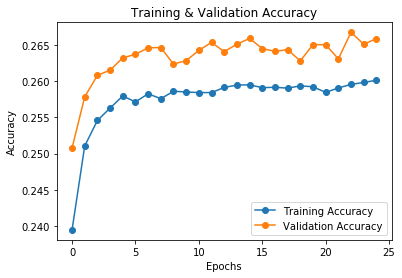

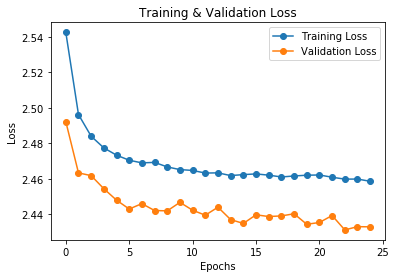

In [0]:
fig1 = plt.figure(1)
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
line1, = plt.plot(history.epoch, history.history['acc'], label='Training Accuracy', marker='o')
line2, = plt.plot(history.epoch, history.history['val_acc'], label='Validation Accuracy', marker='o')
plt.legend(handles=[line1, line2])

fig2 = plt.figure(2)
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
line1, = plt.plot(history.epoch, history.history['loss'], label='Training Loss', marker='o')
line2, = plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss', marker='o')
plt.legend(handles=[line1, line2])

plt.show()
plt.close(fig1)
plt.close(fig2)

In [0]:
preds = model.predict(X_test)
predictions = pd.DataFrame(preds, columns=Y_labels)
predictions.index.name = 'Id'
predictions.to_csv(PREDS_FILE)
print(predictions)

           ARSON   ASSAULT  BAD CHECKS  ...  VEHICLE THEFT  WARRANTS  WEAPON LAWS
Id                                      ...                                      
0       0.003580  0.123263    0.000014  ...       0.037656  0.058088     0.024506
1       0.003889  0.120564    0.000015  ...       0.025490  0.076110     0.031006
2       0.002161  0.118897    0.000025  ...       0.023258  0.048889     0.014876
3       0.003399  0.128159    0.000023  ...       0.036958  0.055454     0.026782
4       0.003399  0.128159    0.000023  ...       0.036958  0.055454     0.026782
...          ...       ...         ...  ...            ...       ...          ...
884257  0.001318  0.090814    0.008017  ...       0.126515  0.017120     0.005638
884258  0.001108  0.067470    0.005612  ...       0.107657  0.013520     0.004855
884259  0.000998  0.079561    0.003290  ...       0.171330  0.012903     0.006183
884260  0.001249  0.085364    0.005196  ...       0.127843  0.021533     0.005928
884261  0.000932

In [0]:
# classifier = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model, epochs=25, batch_size=128)
# score = cross_val_score(classifier, X_train, Y_train, cv=3, scoring='neg_log_loss').mean() * -1
# print(f'Log loss score on training = {score:.5f}')

In [9]:
model = tf.keras.models.load_model(MODEL_FILE)
Y_val_pred = model.predict(X_val)
Y_val_pred = Y_val_pred.argmax(-1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


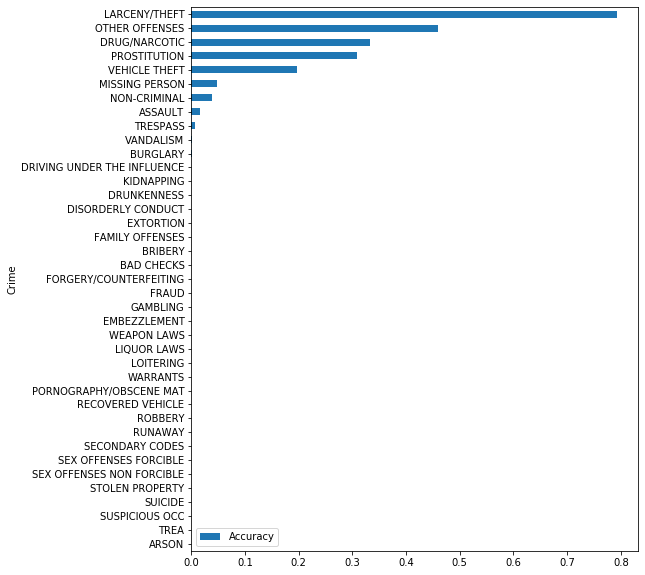

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_val_true, Y_val_pred)
class_accuracies = cm.diagonal()/cm.sum(axis=1)
#print (class_accuracies)
#print(classification_report(y_val_true, Y_val_pred, target_names=Y_labels))

class_ac = pd.DataFrame(data=[Y_labels, class_accuracies], index=['Crime', 'Accuracy']).T
class_ac = class_ac.sort_values(by='Accuracy')
class_ac.plot(x='Crime', y='Accuracy', kind='barh', figsize=(8,10))
#labels, counts = np.unique(raw_train['Category'], return_counts=True)
# y_pos = np.arange(len(Y_labels))
# plt.figure(figsize=(10,5))
# plt.bar(y_pos, class_accuracies, align='edge', width=0.8)
# plt.xticks(y_pos, Y_labels, rotation='vertical')
# plt.ylabel('Accuracy')
# plt.title('Class accuracy')
# plt.subplots_adjust(bottom=0.15)
# plt.show()

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_true, Y_val_pred)

0.26587324184271965